<a href="https://colab.research.google.com/github/mispelledname/ml_tutorials/blob/master/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Regression: predict fuel efficiency**

Regression problems predict the output of a continuous value (a single value).

In [0]:
# use seaborn for pairplot
!pip install seaborn

In [109]:
from __future__ import absolute_import, division, print_function

import os.path

import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

# import tensorflow_docs as tfdocs
# import tensorflow_docs.plots
# import tensorflow_docs.modeling

2.2.0-rc3


## **The Data**
1. Source the dataset
2. Clean the data
3. Split the data into training set and test set
4. Inspect the data
5. Split features from labels
5. Normalize the data 

### **Data set source**
UCI Machine Learning Databases: https://archive.ics.uci.edu/ml/machine-learning-databases/

In [26]:
dataset_path = keras.utils.get_file("auto_mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 4us/step


'/root/.keras/datasets/auto-mpg.data'

Import the data using pandas

In [36]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### **Clean the data**
1. Get rid of unknown values.
2. Convert categorical data to a one-hot. 

In [37]:
dataset.isna().sum()
dataset = dataset.dropna()

origin = dataset.pop("Origin")
dataset["USA"] = (origin == 1) * 1.0
dataset["Europe"] = (origin == 2) * 1.0
dataset["Japan"] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### **Split the data**
80% in training set

20% in test set

In [44]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
281,19.8,6,200.0,85.0,2990.0,18.2,79,1.0,0.0,0.0
229,16.0,8,400.0,180.0,4220.0,11.1,77,1.0,0.0,0.0
150,26.0,4,108.0,93.0,2391.0,15.5,74,0.0,0.0,1.0
145,32.0,4,83.0,61.0,2003.0,19.0,74,0.0,0.0,1.0
182,28.0,4,107.0,86.0,2464.0,15.5,76,0.0,1.0,0.0


### **Inspect the data**
Diagonals show kernel (smooth histogram), off-diagonals show pair plot. 

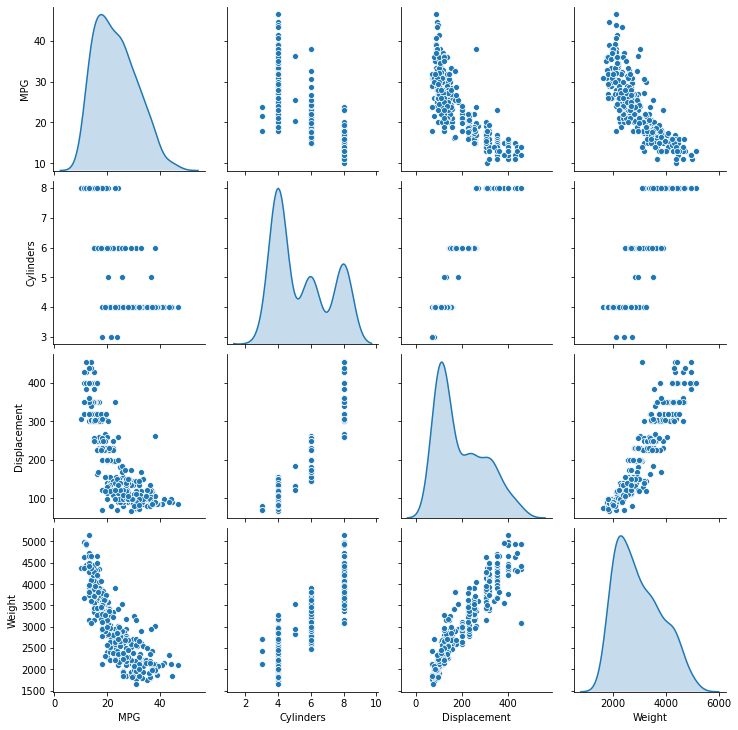

In [45]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Summary statistics of the dataset

In [55]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### **Split features from labels**
Separate the target value ("label") from the features, i.e. what you will train the model to predict. 

In [0]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

### **Normalize the data**
It is good practice to normalize data that uses different scales and ranges, so model is not dependent on units chosen. 

In [0]:
def norm(x):
  return (x - train_stats["mean"]) /train_stats["std"]

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## **The Model**
1. Build the model
2. Train the model
3. Test the model 

### **Build the model**
Use `Sequential` model with two densely connected hidden layers and an output layer that returns a single continuous value. 

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation="relu"), 
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001) # what does this do

  model.compile(loss="mse", 
                optimizer=optimizer,
                metrics=["mae", "mse"]) # what does this do
  return model 

In [0]:
model = build_model()

### **Inspect the model**
`.summary` vprints a description of the model. 

In [99]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Try out a model on a batch sample size of 10. Call `model.predict` on this sample and see that it is taking in the right inputs and outputting a value of the same shape and type. 

In [68]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.20800221],
       [-0.06961679],
       [ 0.24395475],
       [ 0.13033456],
       [ 0.19722167],
       [-0.0423291 ],
       [ 0.246858  ],
       [ 0.48331863],
       [ 0.05620212],
       [ 0.22526088]], dtype=float32)

### **Training the model**
Train the model for 1000 epochs, and record the training and validation accuracy.

`validation_split`: splits off a fraction of the dataset while the model is being trained to test it. 

In [100]:
EPOCHS = 1000

# Display training progress by printing a dot for each epoch completed
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print("")
    print(".", end="")

history = model.fit(
    normed_train_data, train_labels, 
    epochs=EPOCHS, validation_split=0.2, verbose=0, 
    # callbacks=[tfdocs.modeling.EpochDots()]
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

View the trained model results in the `history` object.

In [95]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.554270,1.029314,2.557827,10.952896,2.611372,10.913606,995
996,2.748561,1.047367,2.777145,10.189201,2.488531,10.156282,996
997,2.654880,1.062005,2.694330,10.066522,2.505075,10.031758,997
998,2.763055,1.040579,2.700659,9.594929,2.376636,9.572630,998
999,2.877723,1.091800,2.910323,10.022421,2.459704,9.991446,999


Visualize the model loss using plots:


In [0]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist["epoch"] = history.epoch

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Abs Error [MPG]")
  plt.plot(hist["epoch"], hist["mae"], 
           label="Train Error")
  plt.plot(hist["epoch"], hist["val_mae"], 
           label="Val Error")
  plt.legend()
  plt.ylim([0,5])

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Square Error [$MPG^2$]")
  plt.plot(hist["epoch"], hist["mse"], 
           label="Train Error")
  plt.plot(hist["epoch"], hist["val_mse"], 
           label="Val Error")
  plt.legend()
  plt.ylim([0,20])

# tfdocs.plots.HistoryPlotter(smoothing_std=2)

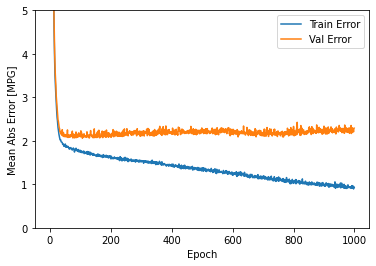

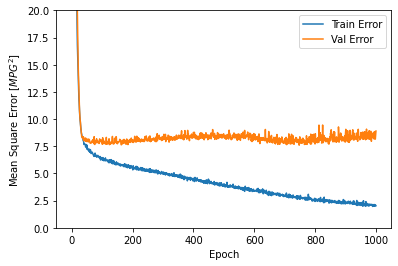

In [101]:
plot_history(history)

### **Prevent overfitting**
- Overfitting looks like the error increasing after some time
- One of the easiest ways to fix this is by stopping training the model once the model stops improving `early_stop`



...........................................................................

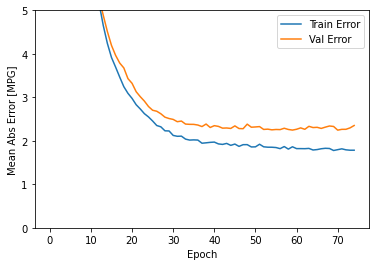

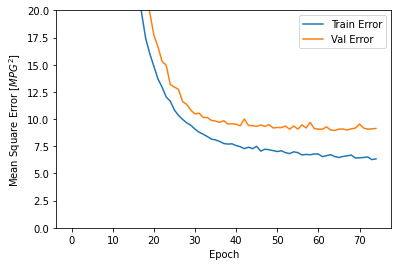

In [102]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
# patience is number of epochs to check for improvement

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, 
                     validation_split=0.2, verbose=0, 
                     callbacks=[early_stop, PrintDot()])

plot_history(history)

### **Evaluating the model**
`model.evaluate` evaluates the model based on test data. 

In [104]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing_set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing_set Mean Abs Error:  1.80 MPG


### **Making predictions**
1. Scatter plot of predicted values vs true values
2. Histogram of error values 

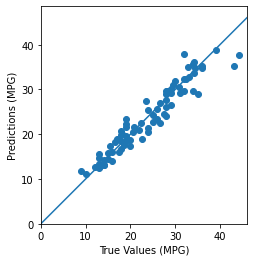

In [105]:
test_predictions = model.predict(normed_test_data).flatten()

def predictions_plot(test_predictions):
  plt.scatter(test_labels, test_predictions)
  plt.xlabel("True Values (MPG)")
  plt.ylabel("Predictions (MPG)")
  plt.axis("equal")
  plt.axis("square")
  plt.xlim([0, plt.xlim()[1]])
  plt.ylim([0, plt.ylim()[1]])
  _ = plt.plot([-100, 100], [-100, 100])

predictions_plot(test_predictions)

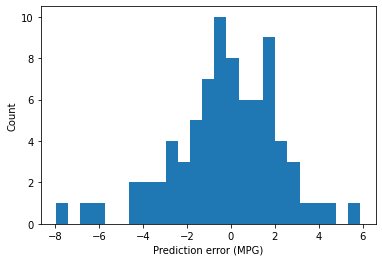

In [108]:
errors = test_predictions - test_labels
def error_plot(error):
  plt.hist(error, bins=25)
  plt.xlabel("Prediction error (MPG)")
  _ = plt.ylabel("Count")

error_plot(errors)
# expect it to be close to Gaussian distribution